# Creative Writing Scoring using Machine Learning

## Preliminary Data Analysis

In [ ]:
# Import Pandas for data frame integration
import pandas as pd

In [ ]:
# Code to upload .csv file from desktop location to Colab
from google.colab import files
uploaded = files.upload()

Saving StoryResults.csv to StoryResults.csv


In [ ]:
# Read in .csv file with story data that will train and test models
StoryResults = pd.read_csv("StoryResults.csv")

In [ ]:
# Ensure that the data was loaded properly
StoryResults.head()

,ID,EnglishFirstLanguage,Story,Rater1,Rater2,Rater3,Rater4,Rater5,RaterMean,SemDis_CuesIn_cbowukwacsubtitle_nf_m,SemDis_CuesOUT_cbowukwacsubtitle_nf_m,WordCount
0,1,n,My lover has left. I miss him so much. I write...,3,3,1,2,3,2.4,1.10815,0.89345,29
1,2,yes,My mom was sending me a letter in the mail abo...,4,3,3,3,2,3.0,1.16734,0.84555,60
2,3,y,I had to buy a stamp at the post office. I am ...,3,1,2,3,2,2.2,0.89265,1.10851,45
3,4,y,I decided it was time for me to send my mom an...,4,5,5,3,4,4.2,1.36365,1.36045,79
4,5,yes,Rachel was sitting in her dorm and decided to ...,3,1,2,3,2,2.2,0.93188,1.02809,69


In [ ]:
# Sample some Pandas dataframe features
StoryResults = StoryResults[["ID","Story","RaterMean"]]

In [ ]:
# View results (this table is not used past this cell)
StoryResults.head()

,ID,Story,RaterMean
0,1,My lover has left. I miss him so much. I write...,2.4
1,2,My mom was sending me a letter in the mail abo...,3.0
2,3,I had to buy a stamp at the post office. I am ...,2.2
3,4,I decided it was time for me to send my mom an...,4.2
4,5,Rachel was sitting in her dorm and decided to ...,2.2


## Text Embedding

For our text embedding models, we will be using John Snow Lab's pretrained transformer models. In this notebook, we are using a base version of the uncased BERT sentence embedding model, implementing it with a pipeline for seamless tokenization and embedding results. We are doing embeddings based on a sentence-by-sentence level, with two different methods of calculating the predicted score: averaged embeddings and averaged story-by-story sentence results.

In [ ]:
# Code needed to load pretrained models into Colab with Java
import os
! apt-get update -qq > /dev/null   
! apt-get install -y openjdk-8-jdk-headless -qq > /dev/null
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["PATH"] = os.environ["JAVA_HOME"] + "/bin:" + os.environ["PATH"]
# Local PySpark install to Colab
! pip install nlu pyspark==2.4.7
# NLU package import to use embedding models
import nlu

     |████████████████████████████████| 204kB 4.9MB/s 
     |████████████████████████████████| 217.9MB 69kB/s 
     |████████████████████████████████| 153kB 42.6MB/s 
     |████████████████████████████████| 204kB 44.8MB/s 
  Created wheel for pyspark: filename=pyspark-2.4.7-py2.py3-none-any.whl size=218279465 sha256=b3290449513ccb3be10edcc21d90035b10b573eb61533319dd9c92035baf3c7d
  Stored in directory: /root/.cache/pip/wheels/34/1f/2e/1e7460f80acf26b08dbb8c53d7ff9e07146f2a68dd5c732be5
Successfully built pyspark


In [ ]:
# Create dataframe with the stories .csv file
df = pd.read_csv('StoryResults.csv')
df.head()

,ID,EnglishFirstLanguage,Story,Rater1,Rater2,Rater3,Rater4,Rater5,RaterMean,SemDis_CuesIn_cbowukwacsubtitle_nf_m,SemDis_CuesOUT_cbowukwacsubtitle_nf_m,WordCount
0,1,n,My lover has left. I miss him so much. I write...,3,3,1,2,3,2.4,1.10815,0.89345,29
1,2,yes,My mom was sending me a letter in the mail abo...,4,3,3,3,2,3.0,1.16734,0.84555,60
2,3,y,I had to buy a stamp at the post office. I am ...,3,1,2,3,2,2.2,0.89265,1.10851,45
3,4,y,I decided it was time for me to send my mom an...,4,5,5,3,4,4.2,1.36365,1.36045,79
4,5,yes,Rachel was sitting in her dorm and decided to ...,3,1,2,3,2,2.2,0.93188,1.02809,69


In [ ]:
# Convert all stories to lowercase for embedding to work with uncased model
for i in range(len(df['Story'])):
  df['Story'][i] = df['Story'][i].lower()

In [ ]:
# Check to see if lowercase function worked
df.head()

,ID,EnglishFirstLanguage,Story,Rater1,Rater2,Rater3,Rater4,Rater5,RaterMean,SemDis_CuesIn_cbowukwacsubtitle_nf_m,SemDis_CuesOUT_cbowukwacsubtitle_nf_m,WordCount
0,1,n,my lover has left. i miss him so much. i write...,3,3,1,2,3,2.4,1.10815,0.89345,29
1,2,yes,my mom was sending me a letter in the mail abo...,4,3,3,3,2,3.0,1.16734,0.84555,60
2,3,y,i had to buy a stamp at the post office. i am ...,3,1,2,3,2,2.2,0.89265,1.10851,45
3,4,y,i decided it was time for me to send my mom an...,4,5,5,3,4,4.2,1.36365,1.36045,79
4,5,yes,rachel was sitting in her dorm and decided to ...,3,1,2,3,2,2.2,0.93188,1.02809,69


In [ ]:
# Create a pipeline to load pretrained TensorFlow Hub embeddings model
pipe = nlu.load('embed_sentence.bert_base_uncased')
# For each story, create an array of stories with subarrays that contain the sentence embeddings for each
# sentence in the story
predictions = pipe.predict(df.Story, output_level='document')
predictions

sent_bert_base_uncased download started this may take some time.
Approximate size to download 392.5 MB
[OK!]
sentence_detector_dl download started this may take some time.
Approximate size to download 354.6 KB
[OK!]


,sentence_embeddings@sent_bert_base_uncased_embeddings,origin_index,document_results
0,"[[0.11486922949552536, 0.12318997830152512, 0....",0,my lover has left. i miss him so much. i write...
1,"[[0.27656030654907227, -0.19394497573375702, 0...",1,my mom was sending me a letter in the mail abo...
2,"[[0.16286955773830414, -0.08463536947965622, 0...",2,i had to buy a stamp at the post office. i am ...
3,"[[0.07835201174020767, 0.056671660393476486, 0...",3,i decided it was time for me to send my mom an...
4,"[[0.001528523163869977, -0.219048410654068, 0....",4,rachel was sitting in her dorm and decided to ...
...,...,...,...
174,"[[0.08850832283496857, -0.08342938870191574, 0...",174,i decided to mail a letter to my long lost fri...
175,"[[-0.024229105561971664, 0.22489111125469208, ...",175,my friend from home enlisted in the air force;...
176,"[[-0.19323651492595673, 0.2418430894613266, 0....",176,i wanted to write a letter to my dog. i sealed...
177,"[[-0.06349384039640427, 0.025435902178287506, ...",177,my husband had just left for the war and i had...


In [ ]:
# Add the rater mean to the table, so it can be used for training and testing labels later on
predictions["RaterMean"] = df["RaterMean"]

In [ ]:
predictions.head()

,sentence_embeddings@sent_bert_base_uncased_embeddings,origin_index,document_results,RaterMean
0,"[[0.11486922949552536, 0.12318997830152512, 0....",0,my lover has left. i miss him so much. i write...,2.4
1,"[[0.27656030654907227, -0.19394497573375702, 0...",1,my mom was sending me a letter in the mail abo...,3.0
2,"[[0.16286955773830414, -0.08463536947965622, 0...",2,i had to buy a stamp at the post office. i am ...,2.2
3,"[[0.07835201174020767, 0.056671660393476486, 0...",3,i decided it was time for me to send my mom an...,4.2
4,"[[0.001528523163869977, -0.219048410654068, 0....",4,rachel was sitting in her dorm and decided to ...,2.2


In [ ]:
# Check to see the number of vectors in each of the sentence embeddings
print(len(predictions['sentence_embeddings@sent_bert_base_uncased_embeddings'][8][2]))

768


In [ ]:
# Change the long name of the embeddings column to "embed"
predictions = predictions.rename(columns={'sentence_embeddings@sent_bert_base_uncased_embeddings':'embed'})

In [ ]:
predictions

,embed,origin_index,document_results,RaterMean
0,"[[0.11486922949552536, 0.12318997830152512, 0....",0,my lover has left. i miss him so much. i write...,2.4
1,"[[0.27656030654907227, -0.19394497573375702, 0...",1,my mom was sending me a letter in the mail abo...,3.0
2,"[[0.16286955773830414, -0.08463536947965622, 0...",2,i had to buy a stamp at the post office. i am ...,2.2
3,"[[0.07835201174020767, 0.056671660393476486, 0...",3,i decided it was time for me to send my mom an...,4.2
4,"[[0.001528523163869977, -0.219048410654068, 0....",4,rachel was sitting in her dorm and decided to ...,2.2
...,...,...,...,...
174,"[[0.08850832283496857, -0.08342938870191574, 0...",174,i decided to mail a letter to my long lost fri...,2.6
175,"[[-0.024229105561971664, 0.22489111125469208, ...",175,my friend from home enlisted in the air force;...,2.2
176,"[[-0.19323651492595673, 0.2418430894613266, 0....",176,i wanted to write a letter to my dog. i sealed...,4.0
177,"[[-0.06349384039640427, 0.025435902178287506, ...",177,my husband had just left for the war and i had...,3.4


In [ ]:
# Split the arrays for each story into their own sentence-by-sentence rows
# Store the embeddings
sent_embed = []
# Store the ID
story_id = []
# Store the labels of each story that the sentences belong to 
rater_score = []
for i in range(len(predictions['embed'])):
  for j in range(len(predictions['embed'][i])):
    sent_embed.append(predictions['embed'][i][j])
    story_id.append(predictions['origin_index'][i])
    rater_score.append(predictions['RaterMean'][i])

In [ ]:
# Create a new dataframe where the rows are individual sentences from all the stories
# Start by making sure the sentences can be grouped later with the stories they belong to
model_data = pd.DataFrame(story_id)
# Add the embeddings
model_data['sent_embed'] = sent_embed
# Add the rater score for the story that each sentence belongs to
model_data['rater_score'] = rater_score
model_data = model_data.rename(columns={0:'story_id'})

In [ ]:
model_data

,story_id,sent_embed,rater_score
0,0,"[0.11486922949552536, 0.12318997830152512, 0.5...",2.4
1,0,"[0.10902881622314453, 0.09608181565999985, 0.5...",2.4
2,1,"[0.27656030654907227, -0.19394497573375702, 0....",3.0
3,1,"[0.045672863721847534, -0.047840919345617294, ...",3.0
4,1,"[-0.04951928183436394, -0.2826027572154999, -0...",3.0
...,...,...,...
546,176,"[0.07186698168516159, 0.0282374769449234, 0.35...",4.0
547,177,"[-0.06349384039640427, 0.025435902178287506, 0...",3.4
548,178,"[-0.0817761942744255, 0.018866777420043945, 0....",4.4
549,178,"[-0.06678958982229233, 0.31447556614875793, 0....",4.4


In [ ]:
# Create columns for each vector in the sentence embeddings
columns = []
for i in range(len(model_data["sent_embed"][0])):
  columns.append("Vector"+str(i))
len(columns)

768

In [ ]:
# Split the arrays into their respective vectors
embedData = pd.DataFrame(model_data['sent_embed'].to_list(), columns=columns)
embedData

,Vector0,Vector1,Vector2,Vector3,Vector4,Vector5,Vector6,Vector7,Vector8,Vector9,Vector10,Vector11,Vector12,Vector13,Vector14,Vector15,Vector16,Vector17,Vector18,Vector19,Vector20,Vector21,Vector22,Vector23,Vector24,Vector25,Vector26,Vector27,Vector28,Vector29,Vector30,Vector31,Vector32,Vector33,Vector34,Vector35,Vector36,Vector37,Vector38,Vector39,...,Vector728,Vector729,Vector730,Vector731,Vector732,Vector733,Vector734,Vector735,Vector736,Vector737,Vector738,Vector739,Vector740,Vector741,Vector742,Vector743,Vector744,Vector745,Vector746,Vector747,Vector748,Vector749,Vector750,Vector751,Vector752,Vector753,Vector754,Vector755,Vector756,Vector757,Vector758,Vector759,Vector760,Vector761,Vector762,Vector763,Vector764,Vector765,Vector766,Vector767
0,0.114869,0.123190,0.566768,-0.170726,0.120058,-0.006833,-0.100719,0.709081,-0.030313,-0.504863,-0.063437,-0.624526,-0.039526,0.418748,-0.026971,0.202049,0.451765,0.179387,-0.211084,0.410802,0.247667,0.070401,-0.075496,0.310084,0.209205,-0.043328,-0.247216,-0.063508,0.077999,-0.143502,0.218002,0.218590,-0.152608,0.236479,0.211785,-0.174688,0.171554,-0.467166,-0.536517,0.167058,...,0.138788,-0.034832,0.127961,0.723602,-0.438567,-0.382194,0.114625,0.301156,0.338654,-0.257517,-0.001865,0.421681,0.189704,0.147353,0.069745,-0.226232,-0.022655,-0.064321,-0.363417,-0.556428,0.487571,0.092602,0.063195,-0.187355,-0.399308,0.375577,-0.072834,-0.300062,-0.296909,-0.563342,0.331857,0.276734,-0.005193,-0.496767,0.135792,-0.126636,-0.230801,-0.096365,0.117465,-0.018755
1,0.109029,0.096082,0.509866,0.138764,0.126427,-0.009722,0.179134,0.456078,0.563863,-0.371852,-0.362217,-0.185716,-0.061486,0.280498,-0.030207,-0.106404,0.011649,0.409764,0.249211,0.013328,-0.040454,0.126694,-0.425041,0.009531,0.115478,0.058522,-0.175078,0.152632,-0.354470,0.070376,0.110281,0.115717,-0.159729,-0.097083,-0.146907,0.141115,0.215552,-0.323865,-0.566934,0.213026,...,-0.051478,-0.007576,-0.031370,0.730086,-0.399062,-0.382516,0.139144,0.024480,-0.005666,0.073382,0.065126,0.044428,-0.154522,0.140848,0.061154,-0.014860,0.050443,-0.041050,-0.174583,-0.530137,0.207403,0.143785,-0.274245,-0.253203,-0.343954,-0.107360,-0.289124,-0.312236,-0.442741,-0.078330,-0.020286,0.099318,0.247260,-0.040781,-0.014584,0.077949,-0.036293,-0.064317,-0.138945,0.248947
2,0.276560,-0.193945,0.251915,-0.028605,0.225643,-0.255532,0.020355,0.699782,-0.257338,-0.384631,0.346870,-0.652964,0.071935,0.614781,-0.161385,0.118933,0.522669,0.403151,-0.172784,0.581524,0.040254,0.338781,0.006591,0.337281,0.781645,-0.159117,0.134845,-0.204150,0.179377,-0.556669,-0.029033,0.016721,-0.317499,-0.082092,-0.159064,-0.152446,0.116590,-0.490057,-0.633017,0.320196,...,0.027771,-0.088775,-0.111749,0.687353,-0.125512,-0.193363,0.489139,0.300061,0.002607,-0.424709,-0.264833,0.112950,0.225291,0.086150,-0.258607,0.162867,-0.322581,-0.175708,-0.419409,-0.316905,0.447513,-0.019405,-0.198497,-0.318834,-0.324228,0.702598,-0.033010,-0.657652,-0.215718,-0.769231,-0.106332,-0.064368,0.180240,-0.394481,0.112589,-0.308954,-0.079155,0.070487,-0.140846,0.201867
3,0.045673,-0.047841,0.055433,0.136138,0.146924,0.350827,0.311866,0.593147,0.001923,-0.138926,0.241344,-0.199228,0.195885,0.393934,-0.141814,-0.163367,0.427509,0.020757,-0.145225,-0.042022,0.015437,-0.042375,-0.011689,0.397166,0.658644,-0.192748,-0.259118,0.009422,-0.331119,-0.187609,0.382017,0.091806,0.064548,0.469985,0.040502,-0.199673,0.018902,-0.279821,-0.425076,-0.159049,...,-0.151196,-0.391812,-0.287653,0.121068,0.003680,-0.325479,-0.076871,0.425013,0.125155,0.190967,-0.070813,0.396973,0.154776,-0.212687,-0.196933,0.127947,-0.459411,-0.355419,-0.112834,-0.341232,0.528204,-0.255776,-0.018205,-0.002218,0.122181,0.195421,0.021396,-0.196183,-0.036813,-0.086546,-0.076584,-0.296976,-0.136441,-0.572004,0.227620,-0.079183,-0.259294,-0.091432,-0.038469,0.353880
4,-0.049519,-0.282603,-0.135511,0.259486,-0.021531,-0.054873,0.289646,0.902916,0.286746,-0.311766,0.282270,-0.521003,-0.030202,0.682470,-0.055190,0.074396,-0.177296,-0.04002

In [ ]:
# Add the rater mean and story ID to the new table
embedData["RaterMean"] = model_data["rater_score"]
embedData["StoryID"] = model_data["story_id"]
embedData

,Vector0,Vector1,Vector2,Vector3,Vector4,Vector5,Vector6,Vector7,Vector8,Vector9,Vector10,Vector11,Vector12,Vector13,Vector14,Vector15,Vector16,Vector17,Vector18,Vector19,Vector20,Vector21,Vector22,Vector23,Vector24,Vector25,Vector26,Vector27,Vector28,Vector29,Vector30,Vector31,Vector32,Vector33,Vector34,Vector35,Vector36,Vector37,Vector38,Vector39,...,Vector730,Vector731,Vector732,Vector733,Vector734,Vector735,Vector736,Vector737,Vector738,Vector739,Vector740,Vector741,Vector742,Vector743,Vector744,Vector745,Vector746,Vector747,Vector748,Vector749,Vector750,Vector751,Vector752,Vector753,Vector754,Vector755,Vector756,Vector757,Vector758,Vector759,Vector760,Vector761,Vector762,Vector763,Vector764,Vector765,Vector766,Vector767,RaterMean,StoryID
0,0.114869,0.123190,0.566768,-0.170726,0.120058,-0.006833,-0.100719,0.709081,-0.030313,-0.504863,-0.063437,-0.624526,-0.039526,0.418748,-0.026971,0.202049,0.451765,0.179387,-0.211084,0.410802,0.247667,0.070401,-0.075496,0.310084,0.209205,-0.043328,-0.247216,-0.063508,0.077999,-0.143502,0.218002,0.218590,-0.152608,0.236479,0.211785,-0.174688,0.171554,-0.467166,-0.536517,0.167058,...,0.127961,0.723602,-0.438567,-0.382194,0.114625,0.301156,0.338654,-0.257517,-0.001865,0.421681,0.189704,0.147353,0.069745,-0.226232,-0.022655,-0.064321,-0.363417,-0.556428,0.487571,0.092602,0.063195,-0.187355,-0.399308,0.375577,-0.072834,-0.300062,-0.296909,-0.563342,0.331857,0.276734,-0.005193,-0.496767,0.135792,-0.126636,-0.230801,-0.096365,0.117465,-0.018755,2.4,0
1,0.109029,0.096082,0.509866,0.138764,0.126427,-0.009722,0.179134,0.456078,0.563863,-0.371852,-0.362217,-0.185716,-0.061486,0.280498,-0.030207,-0.106404,0.011649,0.409764,0.249211,0.013328,-0.040454,0.126694,-0.425041,0.009531,0.115478,0.058522,-0.175078,0.152632,-0.354470,0.070376,0.110281,0.115717,-0.159729,-0.097083,-0.146907,0.141115,0.215552,-0.323865,-0.566934,0.213026,...,-0.031370,0.730086,-0.399062,-0.382516,0.139144,0.024480,-0.005666,0.073382,0.065126,0.044428,-0.154522,0.140848,0.061154,-0.014860,0.050443,-0.041050,-0.174583,-0.530137,0.207403,0.143785,-0.274245,-0.253203,-0.343954,-0.107360,-0.289124,-0.312236,-0.442741,-0.078330,-0.020286,0.099318,0.247260,-0.040781,-0.014584,0.077949,-0.036293,-0.064317,-0.138945,0.248947,2.4,0
2,0.276560,-0.193945,0.251915,-0.028605,0.225643,-0.255532,0.020355,0.699782,-0.257338,-0.384631,0.346870,-0.652964,0.071935,0.614781,-0.161385,0.118933,0.522669,0.403151,-0.172784,0.581524,0.040254,0.338781,0.006591,0.337281,0.781645,-0.159117,0.134845,-0.204150,0.179377,-0.556669,-0.029033,0.016721,-0.317499,-0.082092,-0.159064,-0.152446,0.116590,-0.490057,-0.633017,0.320196,...,-0.111749,0.687353,-0.125512,-0.193363,0.489139,0.300061,0.002607,-0.424709,-0.264833,0.112950,0.225291,0.086150,-0.258607,0.162867,-0.322581,-0.175708,-0.419409,-0.316905,0.447513,-0.019405,-0.198497,-0.318834,-0.324228,0.702598,-0.033010,-0.657652,-0.215718,-0.769231,-0.106332,-0.064368,0.180240,-0.394481,0.112589,-0.308954,-0.079155,0.070487,-0.140846,0.201867,3.0,1
3,0.045673,-0.047841,0.055433,0.136138,0.146924,0.350827,0.311866,0.593147,0.001923,-0.138926,0.241344,-0.199228,0.195885,0.393934,-0.141814,-0.163367,0.427509,0.020757,-0.145225,-0.042022,0.015437,-0.042375,-0.011689,0.397166,0.658644,-0.192748,-0.259118,0.009422,-0.331119,-0.187609,0.382017,0.091806,0.064548,0.469985,0.040502,-0.199673,0.018902,-0.279821,-0.425076,-0.159049,...,-0.287653,0.121068,0.003680,-0.325479,-0.076871,0.425013,0.125155,0.190967,-0.070813,0.396973,0.154776,-0.212687,-0.196933,0.127947,-0.459411,-0.355419,-0.112834,-0.341232,0.528204,-0.255776,-0.018205,-0.002218,0.122181,0.195421,0.021396,-0.196183,-0.036813,-0.086546,-0.076584,-0.296976,-0.136441,-0.572004,0.227620,-0.079183,-0.259294,-0.091432,-0.038469,0.353880,3.0,1
4,-0.049519,-0.282603,-0.135511,0.259486,-0.021531,-0.054873,0.289646,0.902916,0.286746,-0.311766,0.282270,-0.521003,-0.030202,0.682470,-0.055190,0.074396,-0.177296,-0.040028,0.146691,0.221381,0.149571,0.037086,-0.068312,0.398810

In [ ]:
# Create another dataframe for the first method that averages the embeddings of the sentences
# grouped by the stories that they are part of
modelData = embedData.groupby(['StoryID']).mean()

In [ ]:
modelData

,Vector0,Vector1,Vector2,Vector3,Vector4,Vector5,Vector6,Vector7,Vector8,Vector9,Vector10,Vector11,Vector12,Vector13,Vector14,Vector15,Vector16,Vector17,Vector18,Vector19,Vector20,Vector21,Vector22,Vector23,Vector24,Vector25,Vector26,Vector27,Vector28,Vector29,Vector30,Vector31,Vector32,Vector33,Vector34,Vector35,Vector36,Vector37,Vector38,Vector39,...,Vector729,Vector730,Vector731,Vector732,Vector733,Vector734,Vector735,Vector736,Vector737,Vector738,Vector739,Vector740,Vector741,Vector742,Vector743,Vector744,Vector745,Vector746,Vector747,Vector748,Vector749,Vector750,Vector751,Vector752,Vector753,Vector754,Vector755,Vector756,Vector757,Vector758,Vector759,Vector760,Vector761,Vector762,Vector763,Vector764,Vector765,Vector766,Vector767,RaterMean
StoryID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.111949,0.109636,0.538317,-0.015981,0.123243,-0.008277,0.039207,0.582579,0.266775,-0.438358,-0.212827,-0.405121,-0.050506,0.349623,-0.028589,0.047823,0.231707,0.294576,0.019064,0.212065,0.103607,0.098548,-0.250269,0.159807,0.162341,0.007597,-0.211147,0.044562,-0.138235,-0.036563,0.164142,0.167154,-0.156169,0.069698,0.032439,-0.016786,0.193553,-0.395516,-0.551726,0.190042,...,-0.021204,0.048295,0.726844,-0.418815,-0.382355,0.126884,0.162818,0.166494,-0.092067,0.031631,0.233055,0.017591,0.144101,0.065450,-0.120546,0.013894,-0.052686,-0.269000,-0.543282,0.347487,0.118194,-0.105525,-0.220279,-0.371631,0.134109,-0.180979,-0.306149,-0.369825,-0.320836,0.155785,0.188026,0.121034,-0.268774,0.060604,-0.024344,-0.133547,-0.080341,-0.010740,0.115096,2.4
1,0.097319,-0.155743,0.103791,0.174304,0.031800,0.029750,0.225648,0.655301,-0.021928,-0.236272,0.221140,-0.436159,0.100034,0.466925,-0.155083,-0.031429,0.210520,0.085168,-0.035867,0.201892,-0.013967,0.085442,-0.004801,0.309665,0.583244,-0.164962,-0.106838,0.068070,-0.101096,-0.241142,0.134856,0.111943,-0.098960,0.143802,-0.079039,-0.200553,0.130821,-0.249815,-0.494149,0.115703,...,-0.279078,-0.211519,0.313863,-0.210590,-0.228368,0.129785,0.419405,0.085664,-0.123444,-0.017210,0.154892,0.113847,-0.072405,-0.070180,0.110063,-0.398198,-0.083944,-0.291904,-0.364113,0.377369,-0.118495,-0.114281,-0.085316,-0.094997,0.088669,-0.012713,-0.304193,-0.213180,-0.259113,-0.124470,-0.131311,0.074857,-0.369992,0.100048,-0.058920,-0.199929,-0.012844,0.092687,0.175379,3.0
2,0.030175,0.040298,0.381326,-0.038063,0.067319,-0.152418,0.055782,0.517538,0.066604,-0.363989,-0.005361,-0.310349,-0.181819,0.353360,0.159583,0.112479,0.168560,0.126291,0.016089,0.323595,0.037144,-0.023918,-0.028375,0.268596,0.352854,0.096671,-0.073387,0.042190,-0.256686,-0.218007,0.148100,0.093641,-0.143123,0.121554,-0.098636,-0.355808,-0.236291,-0.500277,-0.402557,0.079358,...,-0.288254,0.008738,0.521048,-0.282162,-0.155030,0.103431,0.272439,-0.080934,-0.066697,0.077090,0.179237,0.107481,-0.048023,-0.142425,-0.053337,-0.070408,-0.179846,-0.301441,-0.168607,0.371979,0.091682,0.034796,-0.207048,-0.069491,0.091453,-0.049518,-0.401925,-0.464560,-0.206707,0.151963,0.043009,0.030298,-0.401983,0.091769,0.038588,-0.178737,0.153228,0.205281,0.098251,2.2
3,0.127410,0.151438,0.236467,-0.040971,0.019305,-0.123584,0.186328,0.686705,-0.025077,-0.134721,0.038424,-0.164092,0.034221,0.300333,-0.026102,0.131783,0.214460,0.160254,-0.129701,0.271878,0.235989,0.117544,-0.105075,0.128273,0.350381,-0.018162,0.040847,0.047241,-0.059792,-0.072500,0.149753,-0.002722,-0.007797,0.113417,-0.111505,-0.106660,-0.130482,-0.197790,-0.218141,0.066807,...,-0.113231,-0.142323,0.377241,-0.161870,-0.001330,0.051849,0.155925,-0.164894,-0.157050,-0.086189,0.216994,0.097551,-0.039166,-0.098310,-0.129565,0.004732,-0.056086,-0.061469,-0.199365,0.329367,0.186639,-0.097106,-0.228044,0.121001,0.224843,-0.166986,-0.273113,-0.221416,-0.348713,-0.008722,-0.088855,-0.045914,-0.327761,0.025257,0.015812,0.053299,0.028676,0.172925,0.022391,4.2
4,0.005198,-0.170285,0.062554,0.185868,-0.019944,-0.019379,0.326994,0.626266,-0.149879,-0.086100,0.308064,-0.407663

## Model Building & Evaluation Results

### Linear Regression

Find embeddings for all sentences in the documents as separate rows, average their embedding values, and then run them through the linear regression model to get document-level predicted scores.

In [ ]:
# Import required packages for model building and visualizations
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import train_test_split

#### Linear Regression with Averaged Embeddings

Find embeddings for all sentences in the documents as separate rows, average their embedding values, and then run them through the linear regression model to get document-level predicted scores.

In [ ]:
# Get the model data with the average of the embeddings
data = modelData
# Create a numpy array of the embeddings 
X = data.iloc[:, 0:768].values#.reshape(-1, 1)
# Create a numpy array of the mean rater scores (labels)
Y = data.iloc[:, 768].values#.reshape(-1, 1)
# Create a numpy array of the index for the stories
I = modelData.index.to_numpy()
# Define the linear regression model
linear_regressor = LinearRegression()

In [ ]:
# Check the dimensions of the arrays that were created above
I.shape

(179,)

In [ ]:
X.shape

(179, 768)

In [ ]:
Y.shape

(179,)

In [ ]:
# Split the data into training and testing sets for the embeddings, labels and indices.
X_train, X_test, Y_train, Y_test, I_train, I_test = train_test_split(X, Y, I, test_size=0.20, random_state=42)

In [ ]:
# Check the resulting format
X_test

array([[-0.03757353,  0.0438183 ,  0.13870701, ...,  0.23940229,
         0.03045802, -0.11353131],
       [ 0.06929595,  0.10128518,  0.25501145, ...,  0.08777543,
         0.11277509,  0.13120831],
       [ 0.16446992,  0.14216294,  0.08671321, ..., -0.13781468,
         0.06345559,  0.16942095],
       ...,
       [-0.01561639,  0.11268674,  0.42131011, ...,  0.16185186,
         0.09271395,  0.08318349],
       [ 0.07897313, -0.06593124,  0.07755875, ...,  0.19835321,
        -0.02958595,  0.23308404],
       [-0.01034684, -0.10926898,  0.24164057, ..., -0.07634389,
         0.04788471, -0.10570526]])

In [ ]:
# These are identifiers to correctly associate the results with the right stories
I_test

array([ 78,  16,  65, 114,  76,  19, 122,  24,  66, 152,  45,  42, 111,
        82,  67,  15, 113, 165,  68, 118, 142,  30,   9, 119, 155,  18,
       132,  69,  95, 123,  98, 168, 100, 139,  29, 115])

In [ ]:
# Fit the linear regression model with array of averaged embeddings in each story of the training set
linear_regressor.fit(X_train, Y_train)
# Predict the scores for the testing data with the averaged testing embeddings
Y_pred = linear_regressor.predict(X_test)

In [ ]:
# Here are the predicted creativity scores for the test stories, in an array for now
Y_pred

array([ 2.61853303,  3.43964663,  2.76651498,  4.44486976,  2.54443886,
        2.39901856,  3.65710516,  1.64309106,  0.72626659,  4.40416957,
        2.19287034, -0.76923046,  3.15533753,  3.45389248,  1.89772891,
        3.13397442,  2.04439567,  1.22588603,  4.04329681,  2.6053136 ,
        3.20331698,  3.29025242,  2.77721225,  3.13257213,  2.40512808,
        3.23465531,  2.60147422,  3.28416359,  3.15840525,  1.57366754,
        3.29467777,  2.32127411,  3.1989887 ,  2.55221516,  0.79794298,
        3.88937413])

In [ ]:
# Edit the prediction results to make sure that they are within the bounds of 0 and 5 for the context of the project
for i in range(len(Y_pred)):
  if Y_pred[i] < 0:
    Y_pred[i] = 0
  elif Y_pred[i] > 5:
    Y_pred[i] = 5

In [ ]:
# Check to see if the values updated
Y_pred

array([2.61853303, 3.43964663, 2.76651498, 4.44486976, 2.54443886,
       2.39901856, 3.65710516, 1.64309106, 0.72626659, 4.40416957,
       2.19287034, 0.        , 3.15533753, 3.45389248, 1.89772891,
       3.13397442, 2.04439567, 1.22588603, 4.04329681, 2.6053136 ,
       3.20331698, 3.29025242, 2.77721225, 3.13257213, 2.40512808,
       3.23465531, 2.60147422, 3.28416359, 3.15840525, 1.57366754,
       3.29467777, 2.32127411, 3.1989887 , 2.55221516, 0.79794298,
       3.88937413])

In [ ]:
# Here are the actual rater means for the test stories
Y_test

array([3. , 3.6, 1.8, 3.8, 1.8, 1.4, 4.8, 2.6, 1.8, 4.6, 1.6, 1. , 5. ,
       3. , 2.2, 3.6, 2. , 1.8, 2.8, 2.6, 4. , 3.2, 3.8, 2.4, 1.8, 3.2,
       3.2, 3.6, 3. , 1.4, 3.4, 2.6, 3.4, 3. , 1. , 4.2])

In [ ]:
# Here we can calculate some evaluation metrics
from sklearn import metrics

# Explained Variance Score
evs = metrics.explained_variance_score(Y_test, Y_pred)
# R-Squared Score
r2 = metrics.r2_score(Y_test, Y_pred)
# Mean Absolute Error
mae = metrics.mean_absolute_error(Y_test, Y_pred)
# Mean Absolute Percentage Error
def mean_absolute_percentage_error(Y_test, Y_pred): 
    Y_test, Y_pred = np.array(Y_test), np.array(Y_pred)
    return np.mean(np.abs((Y_test - Y_pred) / Y_test)) * 100

mape = mean_absolute_percentage_error(Y_test, Y_pred)
# Mean Squared Error
mse = metrics.mean_squared_error(Y_test, Y_pred)
# Root Mean Squared Error
rmse = metrics.mean_squared_error(Y_test, Y_pred, squared=False)

print("Evaluation of Averaged Embeddings Method for Linear Regression:")
print(" ")
print("Explained Variance Score: ", evs)
print("R-Squared Score: ", r2)
print("Mean Absolute Error: ", mae)
print("Mean Absolute Percentage Error: ", mape)
print("Mean Squared Error: ", mse)
print("Root Mean Squared Error: ", rmse)

Evaluation of Averaged Embeddings Method for Linear Regression:
 
Explained Variance Score:  0.5740910572459521
R-Squared Score:  0.5570011698068446
Mean Absolute Error:  0.55185869297657
Mean Absolute Percentage Error:  23.384942988664662
Mean Squared Error:  0.477946515686171
Root Mean Squared Error:  0.6913367599702558


In [ ]:
# Correlation
r = np.corrcoef(Y_test, Y_pred)
print(r)

[[1.         0.77682323]
 [0.77682323 1.        ]]


In [ ]:
# Create a dataframe with story ID, prediction results and true rater mean
avgData = pd.DataFrame(I_test)
avgData = avgData.rename(columns={0:'StoryID'})
avgData['predRaterMean'] = Y_pred
avgData['trueRaterMean'] = Y_test

In [ ]:
avgData

,StoryID,predRaterMean,trueRaterMean
0,78,2.618533,3.0
1,16,3.439647,3.6
2,65,2.766515,1.8
3,114,4.444870,3.8
4,76,2.544439,1.8
5,19,2.399019,1.4
6,122,3.657105,4.8
7,24,1.643091,2.6
8,66,0.726267,1.8
9,152,4.404170,4.6


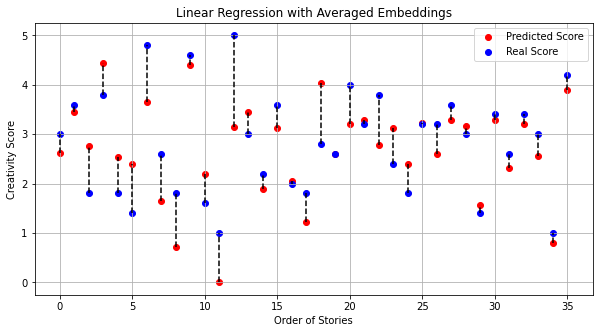

In [ ]:
# Create a plot showing the true and predicted values of rater mean with residuals
f = plt.figure()
f.set_figwidth(10)
f.set_figheight(5)
plt.scatter(avgData.index, Y_pred, color='red')
plt.scatter(avgData.index, Y_test, color='blue')
for i in range(len(I_test)):
  if Y_pred[i] >= Y_test[i]:
    topLim = Y_pred[i]
    botLim = Y_test[i]
    plt.vlines(x=avgData.index[i], ymin=botLim, ymax=topLim, color='k', linestyle='--')
  else:
    botLim = Y_pred[i]
    topLim = Y_test[i]
    plt.vlines(x=avgData.index[i], ymin=botLim, ymax=topLim, color='k', linestyle='--')
plt.grid()
plt.xlabel("Order of Stories")
plt.ylabel("Creativity Score")
plt.legend(["Predicted Score","Real Score"],loc=1)
plt.title("Linear Regression with Averaged Embeddings")
plt.show()

#### Linear Regression with Sentence Embedding

Find embeddings for all sentences in the documents as separate rows, run them through the linear regression model, and average their predicted scores based on story ID at the end.

In [ ]:
# Check the data
predictions

,embed,origin_index,document_results,RaterMean
0,"[[0.11486922949552536, 0.12318997830152512, 0....",0,my lover has left. i miss him so much. i write...,2.4
1,"[[0.27656030654907227, -0.19394497573375702, 0...",1,my mom was sending me a letter in the mail abo...,3.0
2,"[[0.16286955773830414, -0.08463536947965622, 0...",2,i had to buy a stamp at the post office. i am ...,2.2
3,"[[0.07835201174020767, 0.056671660393476486, 0...",3,i decided it was time for me to send my mom an...,4.2
4,"[[0.001528523163869977, -0.219048410654068, 0....",4,rachel was sitting in her dorm and decided to ...,2.2
...,...,...,...,...
174,"[[0.08850832283496857, -0.08342938870191574, 0...",174,i decided to mail a letter to my long lost fri...,2.6
175,"[[-0.024229105561971664, 0.22489111125469208, ...",175,my friend from home enlisted in the air force;...,2.2
176,"[[-0.19323651492595673, 0.2418430894613266, 0....",176,i wanted to write a letter to my dog. i sealed...,4.0
177,"[[-0.06349384039640427, 0.025435902178287506, ...",177,my husband had just left for the war and i had...,3.4


In [ ]:
# Drop irrelevant column
predictions = predictions.drop(['document_results'], axis=1)

In [ ]:
# Check again
predictions

,embed,origin_index,RaterMean
0,"[[0.11486922949552536, 0.12318997830152512, 0....",0,2.4
1,"[[0.27656030654907227, -0.19394497573375702, 0...",1,3.0
2,"[[0.16286955773830414, -0.08463536947965622, 0...",2,2.2
3,"[[0.07835201174020767, 0.056671660393476486, 0...",3,4.2
4,"[[0.001528523163869977, -0.219048410654068, 0....",4,2.2
...,...,...,...
174,"[[0.08850832283496857, -0.08342938870191574, 0...",174,2.6
175,"[[-0.024229105561971664, 0.22489111125469208, ...",175,2.2
176,"[[-0.19323651492595673, 0.2418430894613266, 0....",176,4.0
177,"[[-0.06349384039640427, 0.025435902178287506, ...",177,3.4


In [ ]:
# Create the data that will be used for training and testing, this time before story sentences have unique rows
data = predictions
X = data.iloc[:, 0].values#.reshape(-1, 1)  
Y = data.iloc[:, 2].values#.reshape(-1, 1)
I = data.iloc[:, 1].values

In [ ]:
# Check the array shapes
X.shape

(179,)

In [ ]:
Y.shape

(179,)

In [ ]:
I.shape

(179,)

In [ ]:
# Perform train test split with embeddings, labels, and indices
X_train, X_test, Y_train, Y_test, I_train, I_test = train_test_split(X, Y, I, test_size=0.20, random_state=42)

In [ ]:
# Store the labels for each of the test stories in a holding variable for later scoring
Y_true = Y_test

In [ ]:
# Check the embeddings format
X_test

array([array([[-0.37895569, -0.03885331,  0.17948645, ...,  0.19970533,
         0.05632622,  0.02406334],
       [ 0.17973103, -0.11101859, -0.03052188, ...,  0.3121219 ,
         0.15860151,  0.05013118],
       [-0.06046141,  0.02476782,  0.11399253, ...,  0.1516673 ,
        -0.03769381, -0.25771278],
       [ 0.10939195,  0.30037728,  0.29187092, ...,  0.29411465,
        -0.05540185, -0.27060696]]),
       array([[ 0.08814188,  0.05212675,  0.26508442, ..., -0.00779301,
         0.19404562,  0.10835765],
       [ 0.05045002,  0.1504436 ,  0.24493849, ...,  0.18334387,
         0.03150456,  0.15405896]]),
       array([[ 0.24847764,  0.28799796, -0.00243738, ..., -0.25116739,
         0.1262033 ,  0.10536223],
       [ 0.08046221, -0.00367208,  0.1758638 , ..., -0.02446198,
         0.00070787,  0.23347968]]),
       array([[ 0.22360823,  0.25018138, -0.01886863, ..., -0.2047352 ,
         0.25534436, -0.27076763],
       [ 0.05144345,  0.0327843 ,  0.32806322, ..., -0.19783965,
 

In [ ]:
# Check the story identification format
I_test

array([ 78,  16,  65, 114,  76,  19, 122,  24,  66, 152,  45,  42, 111,
        82,  67,  15, 113, 165,  68, 118, 142,  30,   9, 119, 155,  18,
       132,  69,  95, 123,  98, 168, 100, 139,  29, 115])

In [ ]:
# Create a table with the relevant arrays for test data
testData = pd.DataFrame(I_test)
testData = testData.rename(columns={0:'I_test'})
testData['X_test'] = X_test
testData['Y_test'] = Y_test
testData.head()

,I_test,X_test,Y_test
0,78,"[[-0.3789556920528412, -0.03885330632328987, 0...",3.0
1,16,"[[0.08814188092947006, 0.05212675407528877, 0....",3.6
2,65,"[[0.24847763776779175, 0.2879979610443115, -0....",1.8
3,114,"[[0.22360822558403015, 0.2501813769340515, -0....",3.8
4,76,"[[0.0034685730934143066, -0.2496376633644104, ...",1.8


In [ ]:
# Do the same for the training data
trainData = pd.DataFrame(I_train)
trainData = trainData.rename(columns={0:'I_train'})
trainData['X_train'] = X_train
trainData['Y_train'] = Y_train
trainData.head()

,I_train,X_train,Y_train
0,158,"[[0.2684103548526764, -0.02457369863986969, 0....",1.0
1,31,"[[0.3805398941040039, -0.01445510983467102, 0....",1.2
2,12,"[[-0.10999802500009537, -0.1856888085603714, 0...",1.8
3,51,"[[-0.06396877020597458, 0.04768882319331169, 0...",1.6
4,41,"[[-0.008919842541217804, 0.03542114049196243, ...",3.6


In [ ]:
# Split the training story sentence embeddings into their own rows
sent_embed = []
story_id = []
rater_score = []

for i in range(len(trainData['X_train'])):
  for j in range(len(trainData['X_train'][i])):
    sent_embed.append(trainData['X_train'][i][j])
    story_id.append(trainData['I_train'][i])
    rater_score.append(trainData['Y_train'][i])

In [ ]:
# Create a new train data table with all of the training sentences as rows
trainData = pd.DataFrame(story_id)
trainData['X_train'] = sent_embed
trainData['Y_train'] = rater_score
trainData = trainData.rename(columns={0:'I_train'})

In [ ]:
trainData

,I_train,X_train,Y_train
0,158,"[0.2684103548526764, -0.02457369863986969, 0.0...",1.0
1,31,"[0.3805398941040039, -0.01445510983467102, 0.4...",1.2
2,31,"[0.3223361372947693, 0.07604324072599411, 0.15...",1.2
3,31,"[0.07768259197473526, 0.10145670175552368, 0.1...",1.2
4,12,"[-0.10999802500009537, -0.1856888085603714, 0....",1.8
...,...,...,...
435,92,"[0.04501187056303024, 0.11326387524604797, 0.3...",3.4
436,92,"[0.19170622527599335, 0.07245877385139465, 0.2...",3.4
437,102,"[-0.06327361613512039, 0.2672925591468811, -0....",3.8
438,102,"[0.04527285695075989, 0.2429327815771103, 0.22...",3.8


In [ ]:
# Create columns for each of the vectors in the training sentence embeddings
columns = []
for i in range(len(trainData["X_train"][0])):
  columns.append("Vector"+str(i))
len(columns)

768

In [ ]:
# Spread the training embeddings into columns 
trainData = pd.DataFrame(trainData['X_train'].to_list(), columns=columns)
trainData

,Vector0,Vector1,Vector2,Vector3,Vector4,Vector5,Vector6,Vector7,Vector8,Vector9,Vector10,Vector11,Vector12,Vector13,Vector14,Vector15,Vector16,Vector17,Vector18,Vector19,Vector20,Vector21,Vector22,Vector23,Vector24,Vector25,Vector26,Vector27,Vector28,Vector29,Vector30,Vector31,Vector32,Vector33,Vector34,Vector35,Vector36,Vector37,Vector38,Vector39,...,Vector728,Vector729,Vector730,Vector731,Vector732,Vector733,Vector734,Vector735,Vector736,Vector737,Vector738,Vector739,Vector740,Vector741,Vector742,Vector743,Vector744,Vector745,Vector746,Vector747,Vector748,Vector749,Vector750,Vector751,Vector752,Vector753,Vector754,Vector755,Vector756,Vector757,Vector758,Vector759,Vector760,Vector761,Vector762,Vector763,Vector764,Vector765,Vector766,Vector767
0,0.268410,-0.024574,0.074691,0.329859,-0.060132,0.134522,-0.021371,0.701869,-0.092975,-0.169038,0.337283,-0.465612,-0.169133,0.409022,-0.366214,0.001696,0.303221,-0.124851,-0.284672,0.158017,0.016155,-0.178368,-0.233783,0.308215,0.375043,-0.185332,0.171225,0.171738,-0.324396,0.106279,0.379354,0.141393,-0.169514,0.312475,-0.333516,-0.202158,0.338509,-0.391348,-0.582384,0.124460,...,-0.139594,-0.054544,-0.201260,0.298751,-0.060136,-0.144488,0.188084,0.507338,0.195055,-0.010501,-0.322670,0.298405,0.077530,-0.238262,-0.282620,-0.090482,-0.357115,-0.114269,-0.445376,-0.337283,0.654377,-0.064585,0.177478,-0.058333,-0.162076,0.352044,0.190296,-0.273147,-0.404019,-0.181163,-0.047063,0.061057,-0.051916,-0.295449,0.281152,0.036043,-0.263014,-0.015320,0.109694,0.357972
1,0.380540,-0.014455,0.473156,-0.043915,0.138387,-0.123946,0.173972,0.430649,0.028854,-0.327853,0.308032,-0.282504,0.179013,0.399527,-0.114364,-0.145600,0.367663,0.409452,0.043561,0.263209,0.068302,0.107649,-0.100999,0.141992,0.464177,-0.042473,0.077937,0.114738,0.064481,-0.153094,0.110742,0.095158,0.153998,0.171675,-0.217570,-0.039984,0.059994,-0.274392,-0.509358,0.146873,...,0.365255,-0.024624,0.017551,0.573715,-0.405512,-0.081307,0.127011,-0.009010,0.132870,-0.324089,-0.108978,0.214567,-0.079312,0.280822,-0.085303,0.279762,-0.007924,-0.328598,-0.312576,-0.402408,0.368000,0.033386,-0.234335,-0.498111,-0.511101,0.558850,0.043051,-0.557684,-0.346222,-0.286073,-0.165039,-0.104668,-0.086191,-0.257756,0.130753,-0.034144,-0.036474,0.073529,-0.084019,0.189798
2,0.322336,0.076043,0.159083,-0.005390,0.097032,-0.002768,0.166383,0.319232,0.056398,-0.107850,0.195751,-0.203927,-0.037597,0.267662,-0.028431,-0.023662,0.313355,0.503870,-0.093880,0.204889,-0.144670,0.011880,-0.072830,0.031274,0.473020,0.106475,-0.023424,0.037832,-0.198764,-0.094103,0.320603,-0.118588,0.086465,0.154814,-0.108974,-0.076538,-0.140572,-0.308584,-0.402757,0.044689,...,0.128269,0.111105,0.006929,0.458587,-0.339261,-0.041210,0.094906,-0.079329,0.067119,-0.302028,-0.268420,0.232577,0.063762,-0.087881,-0.272734,0.132297,-0.150090,-0.142770,-0.264051,-0.358517,0.366325,0.054213,-0.248543,-0.136734,-0.467434,0.476559,0.117182,-0.370298,-0.341221,-0.126606,0.101009,-0.383845,0.047467,-0.405347,-0.008683,-0.230667,-0.120266,0.042765,-0.128761,0.282374
3,0.077683,0.101457,0.165813,0.353697,0.308727,-0.010829,0.102616,0.315724,-0.186752,-0.298548,0.258164,-0.522303,-0.060426,0.093994,-0.380251,0.119358,0.334710,0.177919,-0.414885,-0.049961,0.091134,0.130964,0.155638,0.206647,0.503174,-0.065437,0.081533,0.125737,0.052700,-0.002310,0.461823,-0.034587,0.065754,0.136041,-0.174925,-0.051840,0.321883,-0.319057,-0.205042,-0.120210,...,-0.017134,-0.130489,-0.210434,0.517204,-0.394413,-0.125201,0.190680,0.432429,-0.017405,-0.368744,-0.215121,0.210075,0.005994,0.015454,-0.057302,0.200227,-0.433478,-0.366638,-0.284448,-0.705396,0.512381,-0.073153,-0.062206,0.107016,-0.178913,0.447891,-0.125827,-0.288282,-0.256101,0.078387,-0.298138,0.070573,-0.000867,-0.116062,0.310425,0.238556,-0.139239,-0.013582,0.194011,0.186757
4,-0.109998,-0.185689,0.169346,-0.005082,-0.009979,0.203734,0.051256,0.775474,0.016046,-0.522298,0.193601,-0.404704,0.018683,0.377373,-0.100085,0.060805,0.597282,-0.011310,-0.3

In [ ]:
# Add the training story ID and rater score associated with each sentence
trainData["Y_train"] = rater_score
trainData["I_train"] = story_id
trainData

,Vector0,Vector1,Vector2,Vector3,Vector4,Vector5,Vector6,Vector7,Vector8,Vector9,Vector10,Vector11,Vector12,Vector13,Vector14,Vector15,Vector16,Vector17,Vector18,Vector19,Vector20,Vector21,Vector22,Vector23,Vector24,Vector25,Vector26,Vector27,Vector28,Vector29,Vector30,Vector31,Vector32,Vector33,Vector34,Vector35,Vector36,Vector37,Vector38,Vector39,...,Vector730,Vector731,Vector732,Vector733,Vector734,Vector735,Vector736,Vector737,Vector738,Vector739,Vector740,Vector741,Vector742,Vector743,Vector744,Vector745,Vector746,Vector747,Vector748,Vector749,Vector750,Vector751,Vector752,Vector753,Vector754,Vector755,Vector756,Vector757,Vector758,Vector759,Vector760,Vector761,Vector762,Vector763,Vector764,Vector765,Vector766,Vector767,Y_train,I_train
0,0.268410,-0.024574,0.074691,0.329859,-0.060132,0.134522,-0.021371,0.701869,-0.092975,-0.169038,0.337283,-0.465612,-0.169133,0.409022,-0.366214,0.001696,0.303221,-0.124851,-0.284672,0.158017,0.016155,-0.178368,-0.233783,0.308215,0.375043,-0.185332,0.171225,0.171738,-0.324396,0.106279,0.379354,0.141393,-0.169514,0.312475,-0.333516,-0.202158,0.338509,-0.391348,-0.582384,0.124460,...,-0.201260,0.298751,-0.060136,-0.144488,0.188084,0.507338,0.195055,-0.010501,-0.322670,0.298405,0.077530,-0.238262,-0.282620,-0.090482,-0.357115,-0.114269,-0.445376,-0.337283,0.654377,-0.064585,0.177478,-0.058333,-0.162076,0.352044,0.190296,-0.273147,-0.404019,-0.181163,-0.047063,0.061057,-0.051916,-0.295449,0.281152,0.036043,-0.263014,-0.015320,0.109694,0.357972,1.0,158
1,0.380540,-0.014455,0.473156,-0.043915,0.138387,-0.123946,0.173972,0.430649,0.028854,-0.327853,0.308032,-0.282504,0.179013,0.399527,-0.114364,-0.145600,0.367663,0.409452,0.043561,0.263209,0.068302,0.107649,-0.100999,0.141992,0.464177,-0.042473,0.077937,0.114738,0.064481,-0.153094,0.110742,0.095158,0.153998,0.171675,-0.217570,-0.039984,0.059994,-0.274392,-0.509358,0.146873,...,0.017551,0.573715,-0.405512,-0.081307,0.127011,-0.009010,0.132870,-0.324089,-0.108978,0.214567,-0.079312,0.280822,-0.085303,0.279762,-0.007924,-0.328598,-0.312576,-0.402408,0.368000,0.033386,-0.234335,-0.498111,-0.511101,0.558850,0.043051,-0.557684,-0.346222,-0.286073,-0.165039,-0.104668,-0.086191,-0.257756,0.130753,-0.034144,-0.036474,0.073529,-0.084019,0.189798,1.2,31
2,0.322336,0.076043,0.159083,-0.005390,0.097032,-0.002768,0.166383,0.319232,0.056398,-0.107850,0.195751,-0.203927,-0.037597,0.267662,-0.028431,-0.023662,0.313355,0.503870,-0.093880,0.204889,-0.144670,0.011880,-0.072830,0.031274,0.473020,0.106475,-0.023424,0.037832,-0.198764,-0.094103,0.320603,-0.118588,0.086465,0.154814,-0.108974,-0.076538,-0.140572,-0.308584,-0.402757,0.044689,...,0.006929,0.458587,-0.339261,-0.041210,0.094906,-0.079329,0.067119,-0.302028,-0.268420,0.232577,0.063762,-0.087881,-0.272734,0.132297,-0.150090,-0.142770,-0.264051,-0.358517,0.366325,0.054213,-0.248543,-0.136734,-0.467434,0.476559,0.117182,-0.370298,-0.341221,-0.126606,0.101009,-0.383845,0.047467,-0.405347,-0.008683,-0.230667,-0.120266,0.042765,-0.128761,0.282374,1.2,31
3,0.077683,0.101457,0.165813,0.353697,0.308727,-0.010829,0.102616,0.315724,-0.186752,-0.298548,0.258164,-0.522303,-0.060426,0.093994,-0.380251,0.119358,0.334710,0.177919,-0.414885,-0.049961,0.091134,0.130964,0.155638,0.206647,0.503174,-0.065437,0.081533,0.125737,0.052700,-0.002310,0.461823,-0.034587,0.065754,0.136041,-0.174925,-0.051840,0.321883,-0.319057,-0.205042,-0.120210,...,-0.210434,0.517204,-0.394413,-0.125201,0.190680,0.432429,-0.017405,-0.368744,-0.215121,0.210075,0.005994,0.015454,-0.057302,0.200227,-0.433478,-0.366638,-0.284448,-0.705396,0.512381,-0.073153,-0.062206,0.107016,-0.178913,0.447891,-0.125827,-0.288282,-0.256101,0.078387,-0.298138,0.070573,-0.000867,-0.116062,0.310425,0.238556,-0.139239,-0.013582,0.194011,0.186757,1.2,31
4,-0.109998,-0.185689,0.169346,-0.005082,-0.009979,0.203734,0.051256,0.775474,0.016046,-0.522298,0.193601,-0.404704,0.018683,0.377373,-0.100085,0.060805,0.597282,-0.011310,-0.312228,0.513889,0.043613,-0.061019,-0.070604,0.532253

In [ ]:
# Redefine the train embeddings, labels and indices now that the embeddings are spread
data = trainData  # load data set
X_train = data.iloc[:, 0:767].values#.reshape(-1, 1)  
Y_train = data.iloc[:, 768].values#.reshape(-1, 1) 
I_train = data.iloc[:, 769].values

In [ ]:
# Check the format of the training embeddings array
X_train

array([[ 0.26841035, -0.0245737 ,  0.07469141, ..., -0.2630145 ,
        -0.01531966,  0.109694  ],
       [ 0.38053989, -0.01445511,  0.47315606, ..., -0.03647422,
         0.07352886, -0.08401889],
       [ 0.32233614,  0.07604324,  0.15908334, ..., -0.12026554,
         0.04276487, -0.12876052],
       ...,
       [-0.06327362,  0.26729256, -0.06815507, ...,  0.05048794,
         0.09536391,  0.10151751],
       [ 0.04527286,  0.24293278,  0.22362894, ..., -0.12355589,
         0.03177395, -0.02623678],
       [-0.12131384,  0.26961792,  0.27307391, ..., -0.16481937,
         0.34230393,  0.14166895]])

In [ ]:
# Perform the same steps, but for the testing data
sent_embed = []
story_id = []
rater_score = []

for i in range(len(testData['X_test'])):
  for j in range(len(testData['X_test'][i])):
    sent_embed.append(testData['X_test'][i][j])
    story_id.append(testData['I_test'][i])
    rater_score.append(testData['Y_test'][i])

In [ ]:
# Create new dataframe with the test data
testData = pd.DataFrame(story_id)
testData['X_test'] = sent_embed
testData['Y_test'] = rater_score
testData = testData.rename(columns={0:'I_test'})

In [ ]:
testData

,I_test,X_test,Y_test
0,78,"[-0.3789556920528412, -0.03885330632328987, 0....",3.0
1,78,"[0.17973102629184723, -0.1110185906291008, -0....",3.0
2,78,"[-0.06046140566468239, 0.024767817929387093, 0...",3.0
3,78,"[0.109391950070858, 0.3003772795200348, 0.2918...",3.0
4,16,"[0.08814188092947006, 0.05212675407528877, 0.2...",3.6
...,...,...,...
106,115,"[0.3674890100955963, -0.24642522633075714, 0.1...",4.2
107,115,"[0.0750020369887352, -0.05958874151110649, 0.4...",4.2
108,115,"[-0.15522034466266632, 0.12142904102802277, 0....",4.2
109,115,"[-0.253170907497406, -0.13663513958454132, 0.2...",4.2


In [ ]:
# Create columns for each vector of the test sentence embeddings
columns = []
for i in range(len(testData["X_test"][0])):
  columns.append("Vector"+str(i))
len(columns)

768

In [ ]:
# Spread the test embeddings into a new table
testData = pd.DataFrame(testData['X_test'].to_list(), columns=columns)
testData

,Vector0,Vector1,Vector2,Vector3,Vector4,Vector5,Vector6,Vector7,Vector8,Vector9,Vector10,Vector11,Vector12,Vector13,Vector14,Vector15,Vector16,Vector17,Vector18,Vector19,Vector20,Vector21,Vector22,Vector23,Vector24,Vector25,Vector26,Vector27,Vector28,Vector29,Vector30,Vector31,Vector32,Vector33,Vector34,Vector35,Vector36,Vector37,Vector38,Vector39,...,Vector728,Vector729,Vector730,Vector731,Vector732,Vector733,Vector734,Vector735,Vector736,Vector737,Vector738,Vector739,Vector740,Vector741,Vector742,Vector743,Vector744,Vector745,Vector746,Vector747,Vector748,Vector749,Vector750,Vector751,Vector752,Vector753,Vector754,Vector755,Vector756,Vector757,Vector758,Vector759,Vector760,Vector761,Vector762,Vector763,Vector764,Vector765,Vector766,Vector767
0,-0.378956,-0.038853,0.179486,0.201254,0.205466,0.003705,0.085353,0.110534,0.217981,-0.225016,0.224423,-0.235405,-0.037912,0.463480,-0.411652,0.202365,0.203458,0.046403,-0.088411,0.037705,-0.009131,-0.399070,-0.067157,0.360271,0.274690,0.228483,0.021570,-0.136975,0.002802,0.291277,0.284146,-0.128733,0.226807,-0.042455,-0.021177,-0.013902,0.006561,-0.052226,-0.487148,0.218234,...,-0.347766,0.113835,-0.021395,0.525678,-0.370322,-0.443011,-0.170537,0.293527,-0.030861,-0.199320,-0.188357,0.102944,0.365316,0.047949,0.030956,0.296417,-0.376624,-0.286081,-0.053458,-0.145692,-0.022970,-0.023579,-0.213892,-0.140287,-0.172406,0.122964,-0.241258,0.004579,-0.095884,-0.221046,0.060421,0.075379,-0.055667,-0.181122,-0.105206,-0.306112,-0.372512,0.199705,0.056326,0.024063
1,0.179731,-0.111019,-0.030522,0.235617,-0.052310,0.002995,0.435868,0.559883,-0.244948,0.056941,0.482546,-0.177676,0.052570,0.456200,-0.148034,0.276566,0.081976,-0.009244,0.221841,0.488233,-0.133956,-0.144179,0.130355,0.511559,0.551192,-0.262302,-0.122738,0.020013,-0.257103,-0.126242,-0.023689,-0.170483,-0.003536,-0.241356,-0.476688,-0.064080,0.216888,-0.177073,-0.548406,0.297143,...,-0.144844,-0.163984,-0.078701,0.396861,-0.524147,-0.022911,-0.010757,0.352957,-0.028969,-0.278430,-0.115595,0.196945,0.286926,-0.098050,-0.001127,0.241030,-0.272742,-0.449707,-0.357114,-0.380075,0.205994,-0.083109,0.030756,-0.033006,-0.183783,-0.117399,-0.366804,-0.431248,-0.112809,0.128481,0.270841,0.276297,0.105770,-0.341792,0.207572,-0.186025,-0.212871,0.312122,0.158602,0.050131
2,-0.060461,0.024768,0.113993,-0.024533,0.015120,-0.028242,0.550691,0.290213,0.060728,-0.313385,0.426582,-0.310866,-0.045293,0.307832,-0.369969,0.080208,0.086321,0.160584,0.431971,0.152925,-0.092543,-0.242471,-0.010202,0.298801,0.310284,-0.089195,0.075124,0.022827,-0.000404,-0.004615,0.432900,-0.074352,0.110190,-0.068238,-0.036637,0.117779,0.138133,-0.407606,-0.789931,0.368446,...,-0.241306,-0.239321,-0.016057,0.579690,-0.513865,-0.272161,-0.296966,0.519365,-0.244429,-0.151796,-0.130545,-0.012813,0.262725,0.180456,0.015375,0.211937,-0.215234,-0.508692,-0.049322,-0.076827,0.379849,0.056207,-0.216873,0.262657,-0.278056,-0.090706,-0.115599,-0.222020,0.236296,-0.153329,0.215081,-0.217964,0.067577,-0.449468,-0.164107,-0.285608,-0.185365,0.151667,-0.037694,-0.257713
3,0.109392,0.300377,0.291871,-0.033175,-0.141612,-0.073065,0.299549,0.422544,0.306261,-0.090808,0.030832,-0.065304,-0.159050,0.277620,0.067551,-0.100550,-0.217096,-0.273491,0.246636,0.361824,0.312043,0.341596,-0.349400,0.243106,0.356787,-0.215290,-0.305644,-0.298344,-0.160662,0.161591,0.160722,-0.159752,-0.459131,-0.026339,-0.178673,0.263096,0.044706,-0.199539,-0.494458,0.130015,...,-0.317634,0.005698,-0.196212,0.651197,-0.549626,-0.345025,0.178242,0.326679,-0.170858,0.179552,-0.251549,0.293711,0.238094,-0.139218,0.167128,-0.017090,-0.047790,-0.306292,-0.339386,-0.690358,0.373216,-0.056005,-0.244019,-0.482048,-0.140090,-0.437258,-0.237070,-0.361863,0.057548,0.024310,0.056189,-0.065357,0.045872,-0.282520,-0.127193,-0.045838,-0.156620,0.294115,-0.055402,-0.270607
4,0.088142,0.052127,0.265084,0.153286,0.181631,0.162610,0.130163,0.629922,0.197140,-0.204796,0.328679,-0.299467,-0.031918,0.344020,-0.214992,0.152772,0.257206,-0.

In [ ]:
# Add the test story IDs and rater scores
testData["Y_test"] = rater_score
testData["I_test"] = story_id
testData

,Vector0,Vector1,Vector2,Vector3,Vector4,Vector5,Vector6,Vector7,Vector8,Vector9,Vector10,Vector11,Vector12,Vector13,Vector14,Vector15,Vector16,Vector17,Vector18,Vector19,Vector20,Vector21,Vector22,Vector23,Vector24,Vector25,Vector26,Vector27,Vector28,Vector29,Vector30,Vector31,Vector32,Vector33,Vector34,Vector35,Vector36,Vector37,Vector38,Vector39,...,Vector730,Vector731,Vector732,Vector733,Vector734,Vector735,Vector736,Vector737,Vector738,Vector739,Vector740,Vector741,Vector742,Vector743,Vector744,Vector745,Vector746,Vector747,Vector748,Vector749,Vector750,Vector751,Vector752,Vector753,Vector754,Vector755,Vector756,Vector757,Vector758,Vector759,Vector760,Vector761,Vector762,Vector763,Vector764,Vector765,Vector766,Vector767,Y_test,I_test
0,-0.378956,-0.038853,0.179486,0.201254,0.205466,0.003705,0.085353,0.110534,0.217981,-0.225016,0.224423,-0.235405,-0.037912,0.463480,-0.411652,0.202365,0.203458,0.046403,-0.088411,0.037705,-0.009131,-0.399070,-0.067157,0.360271,0.274690,0.228483,0.021570,-0.136975,0.002802,0.291277,0.284146,-0.128733,0.226807,-0.042455,-0.021177,-0.013902,0.006561,-0.052226,-0.487148,0.218234,...,-0.021395,0.525678,-0.370322,-0.443011,-0.170537,0.293527,-0.030861,-0.199320,-0.188357,0.102944,0.365316,0.047949,0.030956,0.296417,-0.376624,-0.286081,-0.053458,-0.145692,-0.022970,-0.023579,-0.213892,-0.140287,-0.172406,0.122964,-0.241258,0.004579,-0.095884,-0.221046,0.060421,0.075379,-0.055667,-0.181122,-0.105206,-0.306112,-0.372512,0.199705,0.056326,0.024063,3.0,78
1,0.179731,-0.111019,-0.030522,0.235617,-0.052310,0.002995,0.435868,0.559883,-0.244948,0.056941,0.482546,-0.177676,0.052570,0.456200,-0.148034,0.276566,0.081976,-0.009244,0.221841,0.488233,-0.133956,-0.144179,0.130355,0.511559,0.551192,-0.262302,-0.122738,0.020013,-0.257103,-0.126242,-0.023689,-0.170483,-0.003536,-0.241356,-0.476688,-0.064080,0.216888,-0.177073,-0.548406,0.297143,...,-0.078701,0.396861,-0.524147,-0.022911,-0.010757,0.352957,-0.028969,-0.278430,-0.115595,0.196945,0.286926,-0.098050,-0.001127,0.241030,-0.272742,-0.449707,-0.357114,-0.380075,0.205994,-0.083109,0.030756,-0.033006,-0.183783,-0.117399,-0.366804,-0.431248,-0.112809,0.128481,0.270841,0.276297,0.105770,-0.341792,0.207572,-0.186025,-0.212871,0.312122,0.158602,0.050131,3.0,78
2,-0.060461,0.024768,0.113993,-0.024533,0.015120,-0.028242,0.550691,0.290213,0.060728,-0.313385,0.426582,-0.310866,-0.045293,0.307832,-0.369969,0.080208,0.086321,0.160584,0.431971,0.152925,-0.092543,-0.242471,-0.010202,0.298801,0.310284,-0.089195,0.075124,0.022827,-0.000404,-0.004615,0.432900,-0.074352,0.110190,-0.068238,-0.036637,0.117779,0.138133,-0.407606,-0.789931,0.368446,...,-0.016057,0.579690,-0.513865,-0.272161,-0.296966,0.519365,-0.244429,-0.151796,-0.130545,-0.012813,0.262725,0.180456,0.015375,0.211937,-0.215234,-0.508692,-0.049322,-0.076827,0.379849,0.056207,-0.216873,0.262657,-0.278056,-0.090706,-0.115599,-0.222020,0.236296,-0.153329,0.215081,-0.217964,0.067577,-0.449468,-0.164107,-0.285608,-0.185365,0.151667,-0.037694,-0.257713,3.0,78
3,0.109392,0.300377,0.291871,-0.033175,-0.141612,-0.073065,0.299549,0.422544,0.306261,-0.090808,0.030832,-0.065304,-0.159050,0.277620,0.067551,-0.100550,-0.217096,-0.273491,0.246636,0.361824,0.312043,0.341596,-0.349400,0.243106,0.356787,-0.215290,-0.305644,-0.298344,-0.160662,0.161591,0.160722,-0.159752,-0.459131,-0.026339,-0.178673,0.263096,0.044706,-0.199539,-0.494458,0.130015,...,-0.196212,0.651197,-0.549626,-0.345025,0.178242,0.326679,-0.170858,0.179552,-0.251549,0.293711,0.238094,-0.139218,0.167128,-0.017090,-0.047790,-0.306292,-0.339386,-0.690358,0.373216,-0.056005,-0.244019,-0.482048,-0.140090,-0.437258,-0.237070,-0.361863,0.057548,0.024310,0.056189,-0.065357,0.045872,-0.282520,-0.127193,-0.045838,-0.156620,0.294115,-0.055402,-0.270607,3.0,78
4,0.088142,0.052127,0.265084,0.153286,0.181631,0.162610,0.130163,0.629922,0.197140,-0.204796,0.328679,-0.299467,-0.031918,0.344020,-0.214992,0.152772,0.257206,-0.004737,-0.333854,0.499761,0.270789,0.030582,0.009831,0.7

In [ ]:
# Redefine testing data now that embeddings are spread
data = testData 
X_test = data.iloc[:, 0:767].values#.reshape(-1, 1)  
Y_test = data.iloc[:, 768].values#.reshape(-1, 1) 
I_test = data.iloc[:, 769].values

In [ ]:
# Create another linear regression for this method, and get predictions for each SENTENCE this time
linear_regressor2 = LinearRegression()
linear_regressor2.fit(X_train, Y_train) 
Y_pred = linear_regressor2.predict(X_test)

In [ ]:
# Check prediction results
Y_pred

array([4.54978786, 3.92685868, 1.68194359, 1.90524138, 5.28061551,
       4.00030027, 1.30817958, 3.08518353, 4.10336081, 7.11318405,
       4.56923732, 1.7489342 , 3.99856276, 2.08631358, 2.5345146 ,
       1.66089467, 1.85413609, 1.40409156, 3.55718988, 4.66184487,
       3.42974216, 2.11288845, 4.40357726, 3.50928366, 1.86235348,
       3.89354407, 3.54756895, 2.42188367, 1.98531624, 1.20661841,
       3.07242148, 3.65195136, 2.38985728, 3.57065064, 0.96837651,
       1.28699269, 2.25496269, 1.8568389 , 3.04711942, 5.14865358,
       3.72714735, 1.47435967, 3.16633345, 4.34928818, 2.61008802,
       2.50969274, 1.87812897, 1.01584201, 1.84261907, 1.18272798,
       3.07704514, 1.97337453, 3.4709845 , 3.67486319, 4.24429347,
       4.73729146, 5.49864625, 3.71963665, 3.83806077, 2.40211689,
       3.4364925 , 3.41965998, 1.60644006, 2.68991157, 2.71385504,
       1.84582264, 4.63419196, 2.64544154, 2.74964213, 2.03051355,
       2.16215854, 2.39805839, 3.38579957, 3.42370743, 4.77712

In [ ]:
# Create a new table that has the story ID and prediction for each sentence in the test data
avgData = pd.DataFrame(I_test)
avgData = avgData.rename(columns={0:'StoryID'})
avgData['predRaterMean'] = Y_pred

In [ ]:
avgData

,StoryID,predRaterMean
0,78,4.549788
1,78,3.926859
2,78,1.681944
3,78,1.905241
4,16,5.280616
...,...,...
106,115,1.433563
107,115,4.160047
108,115,3.192901
109,115,3.893721


In [ ]:
# Modify the table by averaging the predicted scores for each story
avgData = avgData.groupby(['StoryID'], sort=False, as_index=False).mean('predRaterMean')

In [ ]:
# Observe results
avgData

,StoryID,predRaterMean
0,78,3.015958
1,16,4.640458
2,65,2.196682
3,114,4.306656
4,76,2.093908
5,19,2.869316
6,122,3.363873
7,24,2.931338
8,66,1.595967
9,152,3.362186


In [ ]:
# Make sure that the prediction results are within proper bounds of the project context
for i in range(len(avgData['predRaterMean'])):
  if avgData['predRaterMean'][i] < 0:
    avgData['predRaterMean'][i] = 0
  elif avgData['predRaterMean'][i] > 5:
    avgData['predRaterMean'][i] = 5

In [ ]:
# Add the stored test scores from earlier
avgData['trueRaterMean'] = Y_true

In [ ]:
avgData

,StoryID,predRaterMean,trueRaterMean
0,78,3.015958,3.0
1,16,4.640458,3.6
2,65,2.196682,1.8
3,114,4.306656,3.8
4,76,2.093908,1.8
5,19,2.869316,1.4
6,122,3.363873,4.8
7,24,2.931338,2.6
8,66,1.595967,1.8
9,152,3.362186,4.6


In [ ]:
# Create a numpy array of the predicted scores
Y_pred = avgData['predRaterMean'].to_numpy()
Y_pred

array([3.01595788, 4.64045789, 2.19668156, 4.30665583, 2.09390762,
       2.8693156 , 3.36387288, 2.93133754, 1.59596733, 3.36218642,
       2.98025396, 0.96837651, 1.7995981 , 3.97430678, 1.47435967,
       3.37523655, 1.80122124, 1.51267353, 2.52520984, 3.79671372,
       4.65185812, 3.27408253, 2.33673556, 2.96877457, 2.49413251,
       3.47600591, 3.84639117, 3.19016744, 3.04471878, 1.12050569,
       2.83488391, 2.72248824, 3.51367732, 1.84881461, 1.56131476,
       3.89119252])

In [ ]:
# Create a numpy array of the true scores
Y_true = avgData['trueRaterMean'].to_numpy()
Y_true

array([3. , 3.6, 1.8, 3.8, 1.8, 1.4, 4.8, 2.6, 1.8, 4.6, 1.6, 1. , 5. ,
       3. , 2.2, 3.6, 2. , 1.8, 2.8, 2.6, 4. , 3.2, 3.8, 2.4, 1.8, 3.2,
       3.2, 3.6, 3. , 1.4, 3.4, 2.6, 3.4, 3. , 1. , 4.2])

In [ ]:
# Create a numpy array of the story IDs
storyID = avgData['StoryID'].to_numpy()

In [ ]:
storyID

array([ 78,  16,  65, 114,  76,  19, 122,  24,  66, 152,  45,  42, 111,
        82,  67,  15, 113, 165,  68, 118, 142,  30,   9, 119, 155,  18,
       132,  69,  95, 123,  98, 168, 100, 139,  29, 115])

In [ ]:
# Here we can calculate some evaluation metrics
from sklearn import metrics

# Explained Variance Score
evs = metrics.explained_variance_score(Y_true, Y_pred)

# R-Squared Score
r2 = metrics.r2_score(Y_true, Y_pred)

# Mean Absolute Error
mae = metrics.mean_absolute_error(Y_true, Y_pred)

# Mean Absolute Percentage Error
def mean_absolute_percentage_error(Y_true, Y_pred): 
    Y_true, Y_pred = np.array(Y_true), np.array(Y_pred)
    return np.mean(np.abs((Y_true - Y_pred) / Y_true)) * 100
mape = mean_absolute_percentage_error(Y_true, Y_pred)

# Mean Squared Error
mse = metrics.mean_squared_error(Y_true, Y_pred)

# Root Mean Squared Error
rmse = metrics.mean_squared_error(Y_true, Y_pred, squared=False)

print("Evaluation of Averaged Sentence Scores Method for Linear Regression:")
print(" ")
print("Explained Variance Score: ", evs)
print("R-Squared Score: ", r2)
print("Mean Absolute Error: ", mae)
print("Mean Absolute Percentage Error: ", mape)
print("Mean Squared Error: ", mse)
print("Root Mean Squared Error: ", rmse)

Evaluation of Averaged Sentence Scores Method for Linear Regression:
 
Explained Variance Score:  0.25377347764315783
R-Squared Score:  0.2534805691581459
Mean Absolute Error:  0.6488341807139075
Mean Absolute Percentage Error:  24.48473859468681
Mean Squared Error:  0.8054115192749336
Root Mean Squared Error:  0.8974472236710823


In [ ]:
# Check correlation
r = np.corrcoef(Y_true, Y_pred)
print(r)

[[1.         0.59836274]
 [0.59836274 1.        ]]


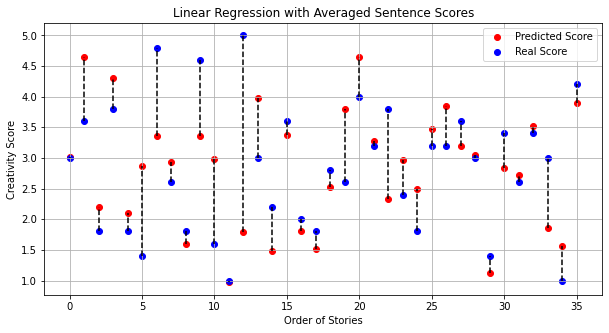

In [ ]:
# Create a plot of the true vs. predicted creative scores
f = plt.figure()
f.set_figwidth(10)
f.set_figheight(5)
plt.scatter(avgData.index, Y_pred, color='red')
plt.scatter(avgData.index, Y_true, color='blue')
for i in range(len(storyID)):
  if Y_pred[i] >= Y_true[i]:
    topLim = Y_pred[i]
    botLim = Y_true[i]
    plt.vlines(x=avgData.index[i], ymin=botLim, ymax=topLim, color='k', linestyle='--')
  else:
    botLim = Y_pred[i]
    topLim = Y_true[i]
    plt.vlines(x=avgData.index[i], ymin=botLim, ymax=topLim, color='k', linestyle='--')
plt.grid()
plt.xlabel("Order of Stories")
plt.ylabel("Creativity Score")
plt.legend(["Predicted Score","Real Score"],loc=1)
plt.title("Linear Regression with Averaged Sentence Scores")
plt.show()

## Single Story Scoring Test

In [ ]:
# Collect a story as input from the user
story = input("Enter a creative story: ")

In [ ]:
a = [story]
# Create a dataframe with the single story
new_df = pd.DataFrame(a, columns = ['Story'])
# Give the story its sentence-by-sentence embeddings
pred = pipe.predict(new_df.Story, output_level='document')

In [ ]:
# Observe the dataframe
pred

,sentence_embeddings@sent_small_bert_L2_128_embeddings,origin_index,document_results
0,"[[-0.9305379986763, 0.1801205426454544, -0.425...",0,"I wrote a letter to my mother while overseas, ..."


In [ ]:
# Simplify the name of the embeddings column
pred = pred.rename(columns={'sentence_embeddings@sent_small_bert_L2_128_embeddings':'embed'})

In [ ]:
pred

,embed,origin_index,document_results
0,"[[-0.9305379986763, 0.1801205426454544, -0.425...",0,"I wrote a letter to my mother while overseas, ..."


In [ ]:
# Drop the index column (uneeded)
pred = pred.drop(["origin_index"], axis=1)

In [ ]:
pred

,embed,document_results
0,"[[-0.9305379986763, 0.1801205426454544, -0.425...","I wrote a letter to my mother while overseas, ..."


In [ ]:
# Split the story embeddings into individual sentence embeddings as arrays
sent_embed = []

for j in range(len(pred['embed'][0])):
  sent_embed.append(pred['embed'][0][j])

In [ ]:
sent_embed

[array([-9.30537999e-01,  1.80120543e-01, -4.25684512e-01, -1.02602434e+00,
        -3.13838959e-01,  6.68474138e-01,  8.15298975e-01,  7.40773678e-01,
        -6.81604683e-01, -3.12611818e-01,  4.28596586e-01,  2.11414903e-01,
         2.62697786e-01, -7.18805194e-01,  7.11903214e-01, -9.24580276e-01,
        -1.32105541e+00, -6.26830906e-02, -9.91640210e-01,  3.12447101e-01,
         1.48711011e-01,  2.25158501e-02,  1.50682241e-01,  1.63352907e+00,
         1.20380998e+00, -1.18362427e+00, -9.30794552e-02,  1.03547919e+00,
        -1.54724956e-01, -8.88671517e-01, -1.92676067e+00, -1.32383323e+00,
        -1.01584947e+00, -2.38100484e-01,  1.59256876e+00, -1.00301099e+00,
         1.04671681e+00, -5.60874462e-01, -1.68068564e+00, -9.26129147e-02,
         7.76982188e-01, -3.17337401e-02, -3.24624687e-01, -1.19540608e+00,
        -5.05734682e-01, -1.22983623e+00, -2.39999861e-01, -7.22475827e-01,
        -2.54598632e-02,  7.76738942e-01, -4.16427761e-01,  8.97757053e-01,
         1.5

In [ ]:
# Create a dataframe of the embeddings, with each sentence as a row
scoring_data = pd.DataFrame()
scoring_data['sent_embed'] = sent_embed

In [ ]:
scoring_data

,sent_embed
0,"[-0.9305379986763, 0.1801205426454544, -0.4256..."
1,"[-1.252753734588623, 0.4811435043811798, -0.27..."


In [ ]:
# Create the embedding vector columns
columns = []
for i in range(len(pred['embed'][0][0])):
  columns.append("Vector"+str(i))
len(columns)

128

In [ ]:
# Put the embeddings back into an array for model prediction
embedData = pd.DataFrame(scoring_data['sent_embed'].to_list(), columns=columns)
data = embedData  # load data set
X_new = data.iloc[:, 0:128].values
# Get predictions for the single story sentences with linear regression model from above
Y_p = linear_regressor.predict(X_new)

In [ ]:
# Print the array of sentence predictions for the story
print(Y_p)

[ 0.13686383 -0.60124222]


In [ ]:
# Calculate the average of the sentence scores (if we are using this method) and produce the final score
finalScore = np.average(Y_p)
finalScore

-0.2321891919709742

In [ ]:
# Make sure the predicted score is within the bounds of 0-5
if finalScore > 5:
  finalScore = 5
elif finalScore < 0:
  finalScore = 0

In [ ]:
# Print the results for the user to see how creative their story is
print("The creativity score for your story is ", round(finalScore, 1), "!")

The creativity score for your story is  0 !
